In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tqdm import tqdm
from tempfile import TemporaryDirectory
import imageio

In [3]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
import sys
sys.path.append("..")

In [5]:
# Import the various experiments we need for the notebook
from sva.experiments import Sine2Phase

# Import the helper functions for Gaussian Processes
from sva.models.gp.single_task_gp import EasySingleTaskGP

# Import the value function
from sva.value import SVF

torch default dtype set to torch.float64


/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A simple 2d example

In [22]:
experiment = Sine2Phase()

In [23]:
experiment.initialize_data(n=3, protocol="random", seed=123)
extent = experiment.get_experimental_domain_mpl_extent()
X = experiment.data.X

In [24]:
# Get the ground truth results
x = experiment.get_dense_coordinates(ppd=100)
y = experiment(x)

In [25]:
svf = SVF()

In [26]:
value = svf(X, experiment(X)).reshape(-1, 1)

In [27]:
# Train a GP on the current data
gp = EasySingleTaskGP.from_default(X, value)
gp.fit_mll()
mu, var = gp.predict(x)

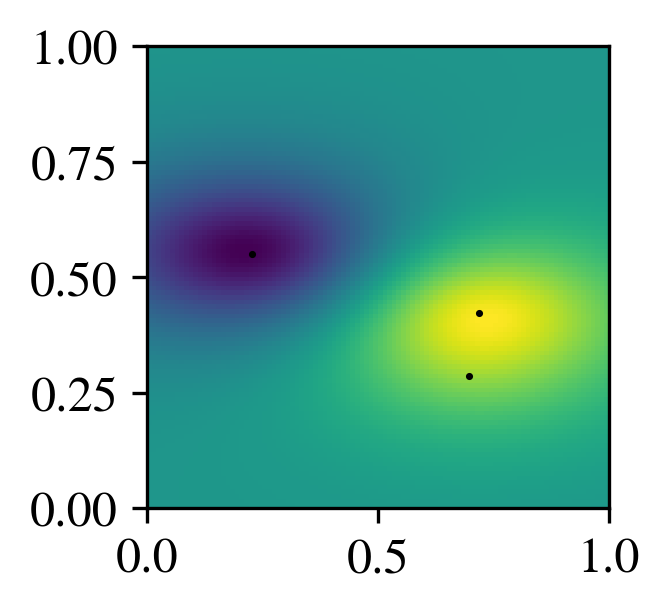

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2), sharex=True, sharey=True)

ax = axs
ax.imshow(mu.reshape(100, 100).T, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(X[:, 0], X[:, 1], color="black", s=0.5)

plt.show()

# Running the experiment

In [6]:
svf = SVF()

In [239]:
experiment = Sine2Phase()
experiment.initialize_data(n=3, protocol="random", seed=123)
extent = experiment.get_experimental_domain_mpl_extent()

In [ ]:
x = experiment.get_dense_coordinates(ppd=100)
y = experiment(x)

In [ ]:
ii_gp_mu = []
ii_gp_var = []

In [ ]:
for iter in tqdm(range(148)):

    X = experiment.data.X
    value = svf(X, experiment(X)).reshape(-1, 1)

    # Train a GP on the current data
     

    # UCB
    state = ask(
        gp.model,
        "UCB",
        bounds=experiment.properties.experimental_domain,
        acquisition_function_kwargs={"beta": 20.0},
        optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100},
    )

    # EI
    # state = ask(
    #     gp.model,
    #     "EI",
    #     bounds=experiment.properties.experimental_domain,
    #     acquisition_function_kwargs={"best_f": value.max()},
    #     optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100},
    # )

    j

    mu, var = gp.predict(x)
    mu = mu.reshape(100, 100).T
    mu -= mu.min()
    mu /= mu.max()
    var = var.reshape(100, 100).T
    var -= var.min()
    var /= var.max()

    ii_gp_mu.append(mu)
    ii_gp_var.append(var)

## Simple plot

In [ ]:
grid = np.linspace(0, 1, 100)
b = 0.5 + 0.25 * np.sin(2.0 * np.pi * grid)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(3, 2), sharex=True, sharey=True)

ax = axs
im = ax.imshow(mu, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(X[:, 0], X[:, 1], color="red", s=0.5, zorder=3)
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

cbar = plt.colorbar(im, ax=ax)
cbar.set_ticks([0, 1])
cbar.set_label(r"$\mathcal{G}(\mathbf{x}) \approx U_i(D_N)$")

plt.show()

## Let's make a GIF of the mean

In [ ]:
with TemporaryDirectory() as f:

    filenames = []

    for ii, (mu, var) in tqdm(enumerate(zip(ii_gp_mu, ii_gp_var))):
    
        fig, axs = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
        
        ax = axs
    
        n = ii + 3
        im = ax.imshow(mu, extent=extent, interpolation='nearest', origin='lower')
        ax.scatter(X[:n, 0], X[:n, 1], color="red", s=0.5, zorder=3)
        ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
    
        ax.set_title(f"$N={n}$")
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_label(r"$\mathcal{G}(\mathbf{x}) \approx U_i(D_N)$")

        filename = f'{f}/{ii}.png'
        filenames.append(filename)

        plt.savefig(filename)
        plt.close()
    
    frames = []
    for filename in filenames:
        frames.append(imageio.imread(filename))
        
    exportname = "sine2phase.gif"
    kwargs = { 'duration': 1.0 }
    imageio.mimsave(exportname, frames, 'GIF', **kwargs)

## Let's make a GIF of the variance

In [ ]:
with TemporaryDirectory() as f:

    filenames = []

    for ii, (mu, var) in tqdm(enumerate(zip(ii_gp_mu, ii_gp_var))):
    
        fig, axs = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
        
        ax = axs
    
        n = ii + 3
        im = ax.imshow(var, extent=extent, interpolation='nearest', origin='lower')
        ax.scatter(X[:n, 0], X[:n, 1], color="red", s=0.5, zorder=3)
        ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
    
        ax.set_title(f"$N={n}$")
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_label(r"$\mathrm{var}(\mathcal{G}(\mathbf{x}))$")

        filename = f'{f}/{ii}.png'
        filenames.append(filename)

        plt.savefig(filename)
        plt.close()
    
    frames = []
    for filename in filenames:
        frames.append(imageio.imread(filename))
        
    exportname = "sine2phase_var.gif"
    kwargs = { 'duration': 1.0 }
    imageio.mimsave(exportname, frames, 'GIF', **kwargs)

# Running the experiment (short version)

In [11]:
svf = SVF()
experiment = Sine2Phase()
experiment.initialize_data(n=3, protocol="random", seed=123)
extent = experiment.get_experimental_domain_mpl_extent()

In [12]:
x = experiment.get_dense_coordinates(ppd=100)
y = experiment(x)

In [13]:
experiment.run_gp_experiment(150, svf=svf)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:26<00:00,  5.69it/s]


In [14]:
grid = np.linspace(0, 1, 100)
b = 0.5 + 0.25 * np.sin(2.0 * np.pi * grid)

In [17]:
gp = experiment.data.history[-1]["easy_gp"]

In [20]:
mu, var = gp.predict(x)
mu = mu.reshape(100, 100).T
mu -= mu.min()
mu /= mu.max()
var = var.reshape(100, 100).T
var -= var.min()
var /= var.max()

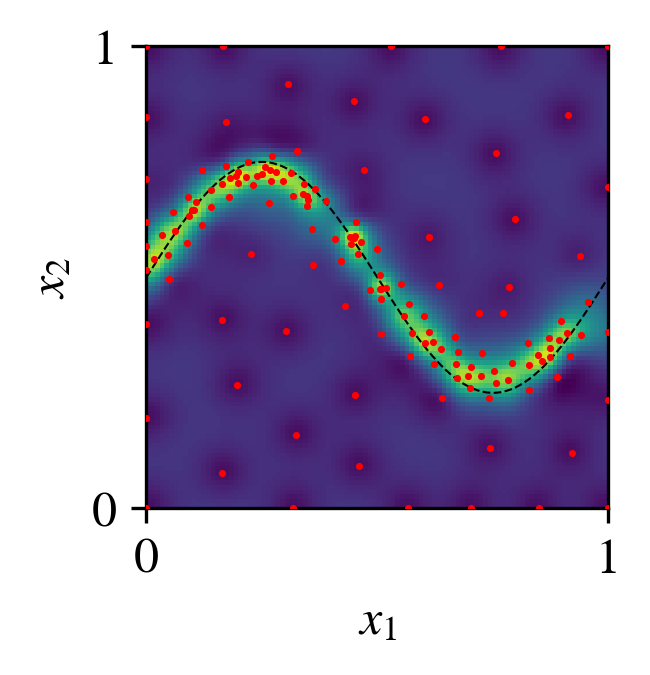

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2), sharex=True, sharey=True)

ax = axs

X = experiment.data.X
im = ax.imshow(mu, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(X[:, 0], X[:, 1], color="red", s=0.5, zorder=3)
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# cbar = plt.colorbar(im, ax=ax)
# cbar.set_ticks([0, 1])
# cbar.set_label(r"$\mathcal{G}(\mathbf{x}) \approx U_i(D_N)$")

plt.show()